# Simulating different telescopes
This notebooks provides examples in how to use the lenstronomy.SimulationAPI modules in simulating (realistic) mock lenses taylored to a specific observation and instrument and makes a montage of different telescope settings currently available.

The module enables to use the astronomical magnitude conventions and can translate those into the lenstronomy core module configurations.

In [3]:
import copy
import os
import numpy as np
import scipy
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#make sure lenstronomy is installed, otherwise install the latest pip version
# try:
#     import lenstronomy
# except:
#     !pip install lenstronomy

# lenstronomy module import
from lenstronomy.Util import image_util, data_util, util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI


## Define camera and observations
As an example, we define the camera and observational settings of a LSST-like observation. We define one camera setting and three different observations corresponding to g,r,i imaging.

For the complete list of possible settings, we refer to the SimulationAPI.observation_api classes. There are pre-configured settings which approximately mimic observations from current and future instruments. Be careful using those and check whether they are sufficiently accurate for your specific science case!

## Configuración de Telescopios: LSST y Euclid

En esta celda se instancian configuraciones de observación para dos telescopios clave: **LSST** y **Euclid**, utilizando las clases provistas por `lenstronomy.SimulationAPI`.

Cada configuración define parámetros realistas como el filtro usado (`band`), el tipo de PSF (punto de dispersión), y los años de observación acumulada (`coadd_years`), lo cual afecta la profundidad y resolución de la simulación.

- **LSST**:
  - Se simulan tres bandas: *g*, *r* e *i*.
  - Se asume una PSF gaussiana y una coadición de imágenes durante 10 años (aproximando el survey completo).

- **Euclid**:
  - Se simulan las bandas *VIS* (visible) y *NIR* (infrarrojo cercano).
  - También con 6 años de coadición de datos.

Esto permite comparar cómo el mismo sistema lente sería observado por diferentes telescopios con distintas resoluciones, PSFs y profundidades.


In [4]:
# Instrument setting from pre-defined configurations

# from lenstronomy.SimulationAPI.ObservationConfig.DES import DES
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid
# from lenstronomy.SimulationAPI.ObservationConfig.Roman import Roman


# Instanciamos configuraciones de LSST para las bandas g, r, i
# Usamos una PSF gaussiana y asumimos 10 años de coadición de imágenes (survey completo)
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=2)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=2)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=2)
lsst = [LSST_g, LSST_r, LSST_i]  # Agrupamos las configuraciones de LSST

# Instanciamos configuraciones de Euclid para las bandas VIS (óptica) y NIR (infrarrojo)
# Asumimos 6 años de coadición de imágenes (duración prevista del survey)
Euclid_g = Euclid(band='VIS', coadd_years=6)
Euclid_r = Euclid(band='VIS', coadd_years=6)
# Euclid no tiene banda 'i', pero podemos usar la banda 'NIR' como referencia
Euclid_i = Euclid(band='VIS', coadd_years=6)  # Si se desea incluir la banda NIR
# Para este ejemplo, solo usaremos VIS
euclid = [Euclid_g, Euclid_r, Euclid_i]  # Agrupamos las configuraciones de Euclid


## Importar una galaxia real para usar como fuente

En este bloque se importa una imagen real de la galaxia espiral **NGC 1300**, que será usada como mapa de brillo superficial para la fuente lenseada. La imagen es preprocesada para adaptarla a los requerimientos de simulación:

1. Se convierte la imagen a escala de grises.
2. Se resta el fondo (mediana de una esquina).
3. Se convierte en imagen cuadrada rellenando con ceros.
4. Se suaviza con un filtro gaussiano.


In [5]:
import os
import numpy as np
import imageio.v2 as imageio
from scipy.ndimage import gaussian_filter

# Determinar ruta a la imagen NGC1300 (asume estructura del repo original de lenstronomy)
path = os.getcwd()
dirpath, _ = os.path.split(path)
module_path, _ = os.path.split(dirpath)
ngc_filename = os.path.join(module_path, 'Data/Galaxies/ngc1300.jpg')

# Leer imagen como flotante (modo 'F'), en escala de grises
ngc_data_1 = imageio.imread(ngc_filename, mode='F', pilmode=None)

# Substraer la mediana del fondo (primeros 200x200 píxeles)
median = np.median(ngc_data_1[:200, :200])
ngc_data = ngc_data_1 - median


In [ ]:
#graficamos ambas imagenes una al lado de la otra
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.imshow(ngc_data_1, cmap='gray', origin='lower')
plt.colorbar()
plt.title('NGC1300 - Original')

plt.subplot(1, 2, 2)
plt.imshow(ngc_data, cmap='gray', origin='lower')
plt.colorbar()
plt.title('NGC1300 - Background Subtracted')
plt.show()


📝 Markdown 2 — Redimensionar a formato cuadrado y suavizar

## Formatear la imagen: cuadrado y suavizado

- Se ajusta la imagen a forma cuadrada para facilitar su procesamiento posterior.
- Se usa un filtro Gaussiano para suavizar los bordes y reducir ruido espurio.


In [ ]:
# Asegurar que la imagen sea cuadrada agregando ceros
nx, ny = np.shape(ngc_data)
n_min = min(nx, ny)
n_max = max(nx, ny)
ngc_square = np.zeros((n_max, n_max))
x_start = int((n_max - nx)/2.)
y_start = int((n_max - ny)/2.)
ngc_square[x_start:x_start+nx, y_start:y_start+ny] = ngc_data

# Aplicar suavizado Gaussiano para limpiar artefactos
sigma = 5  # ancho del kernel gaussiano
ngc_conv = gaussian_filter(ngc_square, sigma, mode='nearest', truncate=6)


📝 Markdown 3 — Reducir resolución y preparar para Shapelets

## Degradar resolución para Shapelets

Se reduce la resolución espacial de la imagen para:

- Minimizar el tiempo computacional en la descomposición en Shapelets.
- Ajustarse a la resolución típica de imágenes astronómicas reales.

Se usa un factor de `25`, lo que baja sustancialmente el número de píxeles.


In [ ]:
from lenstronomy.Util import image_util
from lenstronomy.Util import util

# Definir factor de reducción de resolución
factor = 25
numPix_large = int(len(ngc_conv) / factor)
n_new = int((numPix_large - 1) * factor)

# Cortar imagen original a tamaño múltiplo del factor
ngc_cut = ngc_conv[0:n_new, 0:n_new]

# Crear una grilla de coordenadas para la nueva imagen
x, y = util.make_grid(numPix=numPix_large - 1, deltapix=1)

# Re-escalar la imagen a baja resolución (downsampling)
ngc_data_resized = image_util.re_size(ngc_cut, factor)

# Verificar energía total (suma de píxeles)
print(np.sum(ngc_data_resized))


1788321.7625399919


## Configuración del modelo físico: lentes y fuentes

En esta celda se define la estructura del modelo de lente gravitacional, usando la clase `ModelAPI` de `lenstronomy.SimulationAPI`.

Esta API facilita la creación de objetos `lenstronomy` para:

- **Lente gravitacional** (`LensModel`)
- **Luz del lente** (`LightModel`)
- **Luz de la fuente** (`SourceLight`)
- **Fuentes puntuales** (`PointSource`)

El ejemplo incluye:
- **Plano de lente**: con un perfil `SIE` (Singular Isothermal Ellipsoid) y un componente de `SHEAR` externo.
- **Luz del lente**: un perfil de Sersic elíptico.
- **Luz de la fuente**: una galaxia real interpolada en una grilla (`INTERPOL`).
- **Fuente puntual**: posicionada en la fuente y lenseada por el modelo.


In [ ]:
kwargs_model = {
    'lens_model_list': ['SIE', 'SHEAR'],               # Lente elipsoidal + cizalla externa
    'lens_light_model_list': ['SERSIC_ELLIPSE'],       # Luz de la lente (galaxia elíptica)
    'source_light_model_list': ['INTERPOL'],           # Fuente extendida (imagen interpolada)
    'point_source_model_list': ['SOURCE_POSITION']     # Fuente puntual (ej. cuásar)
}


## Definición de brillo en magnitudes astronómicas

Esta celda muestra cómo configurar perfiles de luz usando **magnitudes astronómicas**, una característica clave de `lenstronomy`. Esto permite controlar directamente el brillo observado, en lugar de especificar amplitudes arbitrarias.

Se define el brillo de tres componentes para la banda *g*:
- **Lente luminosa**: una galaxia elíptica tipo Sersic.
- **Fuente lenseada**: la imagen de NGC1300 como interpolación en una grilla.
- **Fuente puntual**: representa, por ejemplo, un cuásar.

Luego se ajustan los valores para las bandas *r* e *i* modificando las magnitudes según colores espectrales (`g - r`, `g - i`), simulando así observaciones multibanda.


💻 Código 1 — Banda g (magnitudes absolutas)

In [ ]:
# Perfil Sersic para la luz de la lente (galaxia elíptica brillante)
kwargs_lens_light_mag_g = [{
    'magnitude': 15,         # magnitud total
    'R_sersic': 1.6,         # radio efectivo en arcsec
    'n_sersic': 4,           # índice de Sersic (n=4 ≈ perfil de De Vaucouleurs)
    'e1': 0.1, 'e2': -0.1,   # elipticidad en componentes cuadrupolares
    'center_x': 0, 'center_y': 0
}]

# Luz de la fuente (imagen real interpolada)
kwargs_source_mag_g = [{
    'magnitude': 19,             # magnitud total de la fuente
    'image': ngc_data_resized,   # imagen ya reescalada
    'center_x': 0, 'center_y': 0,
    'phi_G': 0,                  # orientación
    'scale': 0.005               # escala espacial en arcsec/píxel
}]

# Fuente puntual (ej. cuásar)
kwargs_ps_mag_g = [{
    'magnitude': 18,
    'ra_source': 0.03, 'dec_source': 0
}]


📝 Markdown 2 — Definición de colores para bandas r e i
markdown

## Ajuste multibanda por colores espectrales

Los modelos de brillo definidos para la banda *g* se duplican para las bandas *r* e *i*, modificando solo sus magnitudes mediante un color (diferencia entre bandas).

Esto simula que:
- El **lente** es más brillante en bandas más rojas.
- La **fuente** es más azul (menos brillante en r e i).
- La **fuente puntual** tiene color plano.



In [ ]:
import copy

# --- Banda r ---
g_r_source = 1    # fuente más brillante en g que en r
g_r_lens = -1     # lente más brillante en r que en g
g_r_ps = 0        # sin color (plano)

kwargs_lens_light_mag_r = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_r[0]['magnitude'] -= g_r_lens  # 15 - (-1) = 16

kwargs_source_mag_r = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_r[0]['magnitude'] -= g_r_source  # 19 - 1 = 18

kwargs_ps_mag_r = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_r[0]['magnitude'] -= g_r_ps  # sin cambio

# --- Banda i ---
g_i_source = 2
g_i_lens = -2
g_i_ps = 0

kwargs_lens_light_mag_i = copy.deepcopy(kwargs_lens_light_mag_g)
kwargs_lens_light_mag_i[0]['magnitude'] -= g_i_lens  # 15 - (-2) = 17

kwargs_source_mag_i = copy.deepcopy(kwargs_source_mag_g)
kwargs_source_mag_i[0]['magnitude'] -= g_i_source  # 19 - 2 = 17

kwargs_ps_mag_i = copy.deepcopy(kwargs_ps_mag_g)
kwargs_ps_mag_i[0]['magnitude'] -= g_i_ps  # sin cambio


## Parámetros del modelo de lente gravitacional

Este bloque define los parámetros físicos del sistema lente. En `lenstronomy`, los ángulos de deflexión se expresan en **arcosegundos**, y las posiciones están dadas en el plano de la imagen (no se necesita cosmología para modelos de un solo plano de lente y fuente).

Se usan dos componentes:
1. **SIE (Singular Isothermal Ellipsoid)**:
   - Modelo elipsoidal de masa que genera deflexiones fuertes y simula galaxias elípticas masivas.
   - Parámetros clave:
     - `theta_E`: radio de Einstein (escala de la lente).
     - `e1`, `e2`: componentes cuadrupolares de la elipticidad.
     - `center_x`, `center_y`: posición de la lente.

2. **SHEAR (Cizalla externa)**:
   - Simula el efecto de masas externas (como cúmulos vecinos) sobre las trayectorias de luz.
   - Parámetros:
     - `gamma1`, `gamma2`: componentes de la cizalla.
     - `ra_0`, `dec_0`: punto de referencia (normalmente 0,0).


In [ ]:
kwargs_lens = [
    {
        'theta_E': 1.2,       # radio de Einstein en arcsec
        'e1': 0.4, 'e2': -0.1,  # elipticidad (componentes cuadrupolares)
        'center_x': 0, 'center_y': 0  # posición de la lente
    },
    {
        'gamma1': 0.03, 'gamma2': 0.01,  # magnitud y orientación de la cizalla externa
        'ra_0': 0, 'dec_0': 0            # centro de referencia para la cizalla
    }
]


## Simulación de imagen en múltiples bandas

Este bloque realiza la simulación del sistema lente en imágenes realistas para tres bandas (*b*, *g*, *r*), combinadas en una imagen RGB sintética. Utiliza la clase `SimAPI` de `lenstronomy.SimulationAPI`, que simplifica la interacción con `ImageModel` y permite:

- Convertir magnitudes a amplitudes físicas.
- Simular imágenes para cada banda.
- Agregar ruido instrumental.
- Fusionar los resultados en una imagen RGB para análisis visual.

Los pasos principales incluyen:
1. Definición del tamaño de imagen y parámetros numéricos (`kwargs_numerics`).
2. Conversión de configuraciones de banda (`ConfigList`) en objetos simulación.
3. Simulación de las tres bandas (b, g, r).
4. Conversión de magnitudes a amplitudes físicas para cada componente.
5. Cálculo de imágenes lenseadas para cada banda.
6. Adición de ruido instrumental.
7. Fusión en imagen RGB con escala por percentil 95.


In [ ]:
# from lenstronomy.SimulationAPI.sim_api import SimAPI
# from lenstronomy.Util import plot_util
# import numpy as np

# Número de píxeles por eje en la imagen simulada
numpix = 64

# Parámetros numéricos de simulación (ej. resolución para fuentes puntuales)
kwargs_numerics = {
    'point_source_supersampling_factor': 1
}

def simulate_rgb(ConfigList, size, kwargs_numerics):
    band_b, band_g, band_r = ConfigList
    kwargs_b_band = band_b.kwargs_single_band()
    kwargs_g_band = band_g.kwargs_single_band()
    kwargs_r_band = band_r.kwargs_single_band()

    # Calcula número de píxeles ajustado a la escala angular (arcsec/pix)
    pixel_scale = kwargs_g_band['pixel_scale']
    numpix = int(round(size / pixel_scale))

    # Crear objetos SimAPI por banda
    sim_b = SimAPI(numpix=numpix, kwargs_single_band=kwargs_b_band, kwargs_model=kwargs_model)
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model)

    # Crear instancias de ImageModel para simular imágenes
    imSim_b = sim_b.image_model_class(kwargs_numerics)
    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)

    # Convertir magnitudes a amplitudes físicas para cada componente
    kwargs_lens_light_g, kwargs_source_g, kwargs_ps_g = sim_b.magnitude2amplitude(
        kwargs_lens_light_mag_g, kwargs_source_mag_g, kwargs_ps_mag_g)
    kwargs_lens_light_r, kwargs_source_r, kwargs_ps_r = sim_g.magnitude2amplitude(
        kwargs_lens_light_mag_r, kwargs_source_mag_r, kwargs_ps_mag_r)
    kwargs_lens_light_i, kwargs_source_i, kwargs_ps_i = sim_r.magnitude2amplitude(
        kwargs_lens_light_mag_i, kwargs_source_mag_i, kwargs_ps_mag_i)

    # Generar imágenes lenseadas por banda (¡nota cómo se alternan para RGB!)
    image_b = imSim_b.image(kwargs_lens, kwargs_source_g, kwargs_lens_light_g, kwargs_ps_g)
    image_g = imSim_g.image(kwargs_lens, kwargs_source_r, kwargs_lens_light_r, kwargs_ps_r)
    image_r = imSim_r.image(kwargs_lens, kwargs_source_i, kwargs_lens_light_i, kwargs_ps_i)

    # Agregar ruido instrumental simulado
    image_b += sim_b.noise_for_model(model=image_b)
    image_g += sim_g.noise_for_model(model=image_g)
    image_r += sim_r.noise_for_model(model=image_r)

    # Fusionar las bandas en una imagen RGB normalizada por percentil 95
    img = np.zeros((image_g.shape[0], image_g.shape[1], 3), dtype=float)

    def _scale_max(image): 
        flat = image.flatten()
        flat.sort()
        return flat[int(len(flat) * 0.95)]

    img[:, :, 0] = plot_util.sqrt(image_b, scale_min=0, scale_max=_scale_max(image_b))  # Red
    img[:, :, 1] = plot_util.sqrt(image_g, scale_min=0, scale_max=_scale_max(image_g))  # Green
    img[:, :, 2] = plot_util.sqrt(image_r, scale_min=0, scale_max=_scale_max(image_r))  # Blue

    # Devuelve imagen RGB y clase de datos
    data_class = sim_b.data_class
    return img, data_class


## Comparación de simulaciones entre surveys: LSST y Euclid

Esta celda ejecuta la simulación multibanda usando las configuraciones definidas previamente (PSF, pixel scale, ruido, filtros) y compara el mismo sistema lente observado desde diferentes telescopios.

Cada imagen muestra el mismo sistema de lente en una caja de `6"` x `6"`.

- **LSST**: resolución terrestre (seeing limitado), PSF gaussiana, pixel scale amplio.
- **Euclid**: alta resolución espacial, mejor recuperación de detalles finos.
- **Roman** y **DES** están mencionados pero no definidos en las celdas previas. Para que funcionen, deben crearse con objetos similares a `LSST` o `Euclid`.

Además, cada panel muestra una barra de escala de `1"`, para referencia visual.


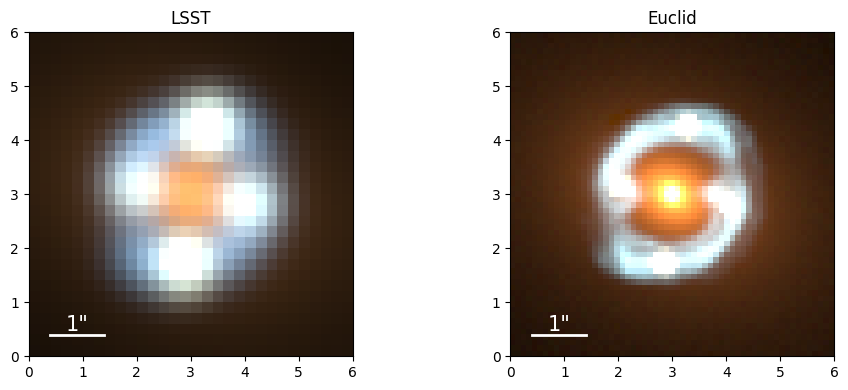

In [ ]:
size = 6.  # Tamaño de la imagen en arcsec

# Simular imágenes RGB para cada survey
# Nota: 'des' y 'roman' deben ser definidos previamente, como se hizo con 'lsst' y 'euclid'
img_lsst, coords_lss = simulate_rgb(lsst, size=size, kwargs_numerics=kwargs_numerics)
img_euclid, coords_euclid = simulate_rgb(euclid, size=size, kwargs_numerics=kwargs_numerics)

# Gráfica de comparación
from lenstronomy.Plots.plot_util import scale_bar
import matplotlib.pyplot as plt

f, axes = plt.subplots(1, 2, figsize=(10, 4))  # 2 en lugar de 3

# LSST
ax = axes[0]
ax.imshow(img_lsst, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('LSST')
scale_bar(ax, d=size, dist=1., text='1"', color='w', font_size=15, flipped=False)

# Euclid
ax = axes[1]
ax.imshow(img_euclid, aspect='equal', origin='lower', extent=[0, size, 0, size])
ax.set_title('Euclid')
scale_bar(ax, d=size, dist=1., text='1"', color='w', font_size=15, flipped=False)

plt.tight_layout()
plt.show()


---
# Generando una imagen a partir de un sersic



In [ ]:
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST

# Instrumento LSST banda g, coadición de 10 años
obs_lsst_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
kwargs_band = obs_lsst_g.kwargs_single_band()


In [ ]:
kwargs_model = {
    'lens_model_list': ['SIE'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}


In [ ]:
# Lente SIE
kwargs_lens = [{'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}]

# Fuente tipo Sersic
kwargs_source_mag = [{
    'magnitude': 21,
    'R_sersic': 0.4,
    'n_sersic': 1,
    'e1': 0.05,
    'e2': -0.05,
    'center_x': 0.1,
    'center_y': 0.05
}]


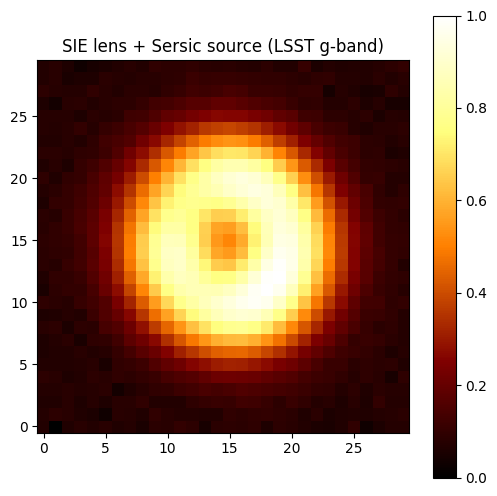

In [ ]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util
import matplotlib.pyplot as plt

# resolución
size = 6.0  # arcsec
pixel_scale = kwargs_band['pixel_scale']
numpix = int(round(size / pixel_scale))

# crear simulador
sim = SimAPI(numpix=numpix, kwargs_single_band=kwargs_band, kwargs_model=kwargs_model)

# convertir magnitudes a amplitudes
_, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])

# modelo de imagen
kwargs_numerics = {'point_source_supersampling_factor': 1}
imSim = sim.image_model_class(kwargs_numerics)

# generar imagen
image = imSim.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_source,
                    kwargs_lens_light=None, kwargs_ps=None)

# agregar ruido
image += sim.noise_for_model(image)

# mostrar
plt.figure(figsize=(6,6))
plt.imshow(plot_util.sqrt(image), origin='lower', cmap='afmhot')
plt.title('SIE lens + Sersic source (LSST g-band)')
plt.colorbar()
plt.show()


---
# Modelado multibanda

In [ ]:
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST

LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)

lsst_bands = [LSST_g, LSST_r, LSST_i]


In [ ]:
kwargs_model = {
    'lens_model_list': ['SIE'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

kwargs_lens = [{'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}]


In [ ]:
# magnitud en g-band (base)
mag_g = 21

# colores
g_r = 1.0
g_i = 2.0

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': 0.1, 'center_y': 0.05}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]


In [ ]:
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util
import matplotlib.pyplot as plt

def simulate_rgb_sersic(ConfigList, kwargs_model, lens_params, source_mags, size=6, kwargs_numerics=None):
    band_g, band_r, band_i = ConfigList
    kw_g, kw_r, kw_i = band_g.kwargs_single_band(), band_r.kwargs_single_band(), band_i.kwargs_single_band()
    
    pixel_scale = kw_g['pixel_scale']
    numpix = int(round(size / pixel_scale))

    sim_g = SimAPI(numpix, kw_g, kwargs_model)
    sim_r = SimAPI(numpix, kw_r, kwargs_model)
    sim_i = SimAPI(numpix, kw_i, kwargs_model)

    _, source_g, _ = sim_g.magnitude2amplitude([], source_mags[0], [])
    _, source_r, _ = sim_r.magnitude2amplitude([], source_mags[1], [])
    _, source_i, _ = sim_i.magnitude2amplitude([], source_mags[2], [])

    imSim_g = sim_g.image_model_class(kwargs_numerics)
    imSim_r = sim_r.image_model_class(kwargs_numerics)
    imSim_i = sim_i.image_model_class(kwargs_numerics)

    img_g_raw = imSim_g.image(lens_params, source_g, None, None)
    img_g = img_g_raw + sim_g.noise_for_model(model=img_g_raw)
    img_r_raw = imSim_r.image(lens_params, source_r, None, None)
    img_r = img_r_raw + sim_r.noise_for_model(model=img_r_raw)
    img_i_raw = imSim_i.image(lens_params, source_i, None, None)
    img_i = img_i_raw + sim_i.noise_for_model(model=img_i_raw)
    # Escalado y fusión
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        return flat[int(len(flat)*0.95)]

    img = np.zeros((numpix, numpix, 3), dtype=float)
    img[:,:,0] = plot_util.sqrt(img_i, scale_min=0, scale_max=_scale_max(img_i))  # R en rojo
    img[:,:,1] = plot_util.sqrt(img_r, scale_min=0, scale_max=_scale_max(img_r))  # G en verde
    img[:,:,2] = plot_util.sqrt(img_g, scale_min=0, scale_max=_scale_max(img_g))  # B en azul
    return img


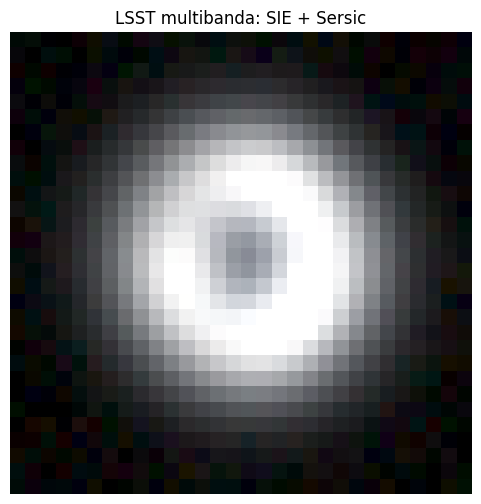

In [ ]:
kwargs_numerics = {'point_source_supersampling_factor': 1}

img_rgb = simulate_rgb_sersic(
    ConfigList=lsst_bands,
    kwargs_model=kwargs_model,
    lens_params=kwargs_lens,
    source_mags=[kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i],
    size=6.0,
    kwargs_numerics=kwargs_numerics
)

plt.figure(figsize=(6,6))
plt.imshow(img_rgb, origin='lower')
plt.title("LSST multibanda: SIE + Sersic")
plt.axis('off')
plt.show()


---

# Dataset con y sin ruido...

In [88]:
from lenstronomy.SimulationAPI.ObservationConfig.LSST import LSST
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.Plots import plot_util
import matplotlib.pyplot as plt
import numpy as np

# Configuraciones por banda
LSST_g = LSST(band='g', psf_type='GAUSSIAN', coadd_years=10)
LSST_r = LSST(band='r', psf_type='GAUSSIAN', coadd_years=10)
LSST_i = LSST(band='i', psf_type='GAUSSIAN', coadd_years=10)

bands = [LSST_g, LSST_r, LSST_i]

# Modelo físico
kwargs_model = {
    'lens_model_list': ['SIE'],
    'source_light_model_list': ['SERSIC_ELLIPSE'],
    'lens_light_model_list': [],
    'point_source_model_list': []
}

kwargs_lens = [{'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}]

# Colores por banda
mag_g = 21
g_r = 1.0
g_i = 2.0

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': 0.1, 'center_y': 0.05}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

source_mags = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]


In [89]:
def simulate_rgb_pair(band_configs, model_config, lens_params, source_mag_list, size=6.0, kwargs_numerics=None):
    images_clean, images_noisy = [], []

    for band_config, kwargs_source_mag in zip(band_configs, source_mag_list):
        kw_band = band_config.kwargs_single_band()
        pixel_scale = kw_band['pixel_scale']
        numpix = int(round(size / pixel_scale))

        sim = SimAPI(numpix, kw_band, model_config)
        _, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])
        imSim = sim.image_model_class(kwargs_numerics)

        image = imSim.image(kwargs_lens=lens_params, kwargs_source=kwargs_source,
                            kwargs_lens_light=None, kwargs_ps=None)

        images_clean.append(image)
        images_noisy.append(image + sim.noise_for_model(image))

    return np.stack(images_clean, axis=-1), np.stack(images_noisy, axis=-1)


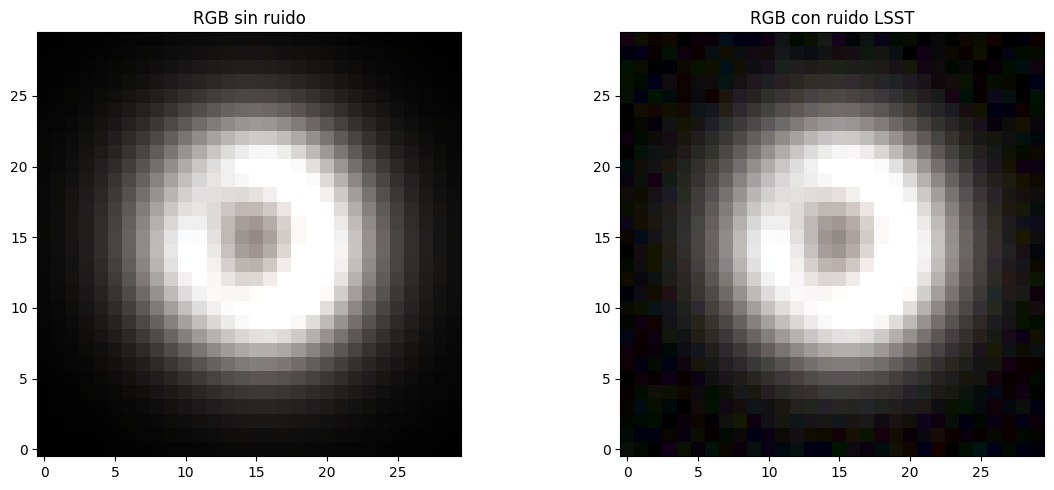

In [90]:
kwargs_numerics = {'point_source_supersampling_factor': 1}

img_clean, img_noisy = simulate_rgb_pair(
    band_configs=bands,
    model_config=kwargs_model,
    lens_params=kwargs_lens,
    source_mag_list=source_mags,
    size=6.0,
    kwargs_numerics=kwargs_numerics
)

# Escalado raíz cuadrada para visualización
def scale_image_rgb(img):
    def _scale_max(image): 
        flat=image.flatten()
        flat.sort()
        return flat[int(len(flat)*0.95)]
    img_scaled = np.zeros_like(img)
    for i in range(3):
        img_scaled[..., i] = plot_util.sqrt(img[..., i], scale_min=0, scale_max=_scale_max(img[..., i]))
    return img_scaled

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(scale_image_rgb(img_clean), origin='lower')
axes[0].set_title("RGB sin ruido")

axes[1].imshow(scale_image_rgb(img_noisy), origin='lower')
axes[1].set_title("RGB con ruido LSST")

plt.tight_layout()
plt.show()


#### Euclid

In [91]:
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

# Definimos tres instancias VIS para simular una pseudo RGB
Euclid_g = Euclid(band='VIS', coadd_years=6)
Euclid_r = Euclid(band='VIS', coadd_years=6)
Euclid_i = Euclid(band='VIS', coadd_years=6)

euclid_bands = [Euclid_g, Euclid_r, Euclid_i]

# Definimos colores artificiales
mag_g = 18
g_r = 0.8
g_i = 1.6

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': 0.1, 'center_y': 0.05}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

source_mags_euclid = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]


In [92]:
img_clean_euclid, img_noisy_euclid = simulate_rgb_pair(
    band_configs=euclid_bands,
    model_config=kwargs_model,
    lens_params=kwargs_lens,
    source_mag_list=source_mags_euclid,
    size=6.0,
    kwargs_numerics=kwargs_numerics
)


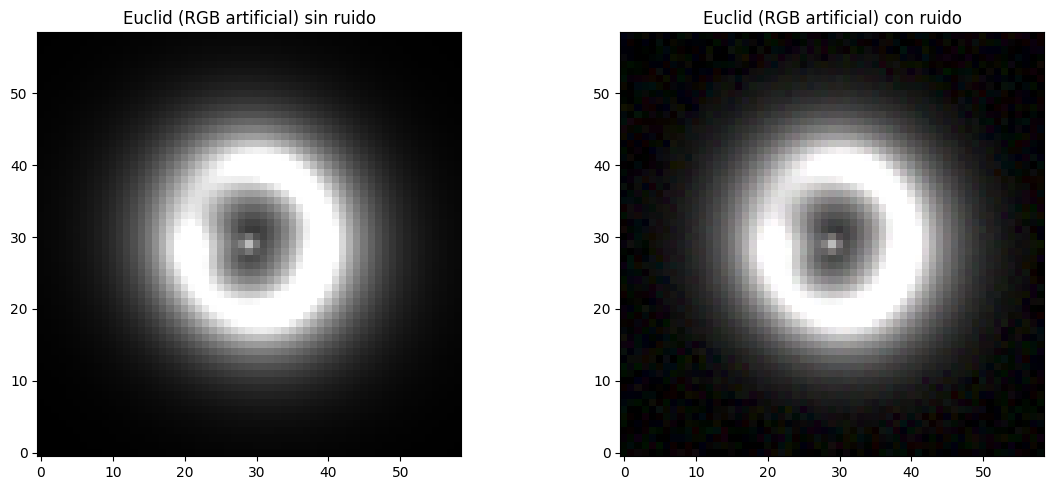

In [93]:
def scale_image_rgb(img):  # img shape: (N, N, 3)
    def _scale_max(image): 
        flat = image.flatten()
        flat.sort()
        return flat[int(len(flat)*0.95)]
    img_scaled = np.zeros_like(img)
    for i in range(3):
        img_scaled[..., i] = plot_util.sqrt(img[..., i], scale_min=0, scale_max=_scale_max(img[..., i]))
    return img_scaled

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(scale_image_rgb(img_clean_euclid), origin='lower')
axes[0].set_title("Euclid (RGB artificial) sin ruido")

axes[1].imshow(scale_image_rgb(img_noisy_euclid), origin='lower')
axes[1].set_title("Euclid (RGB artificial) con ruido")

plt.tight_layout()
plt.show()


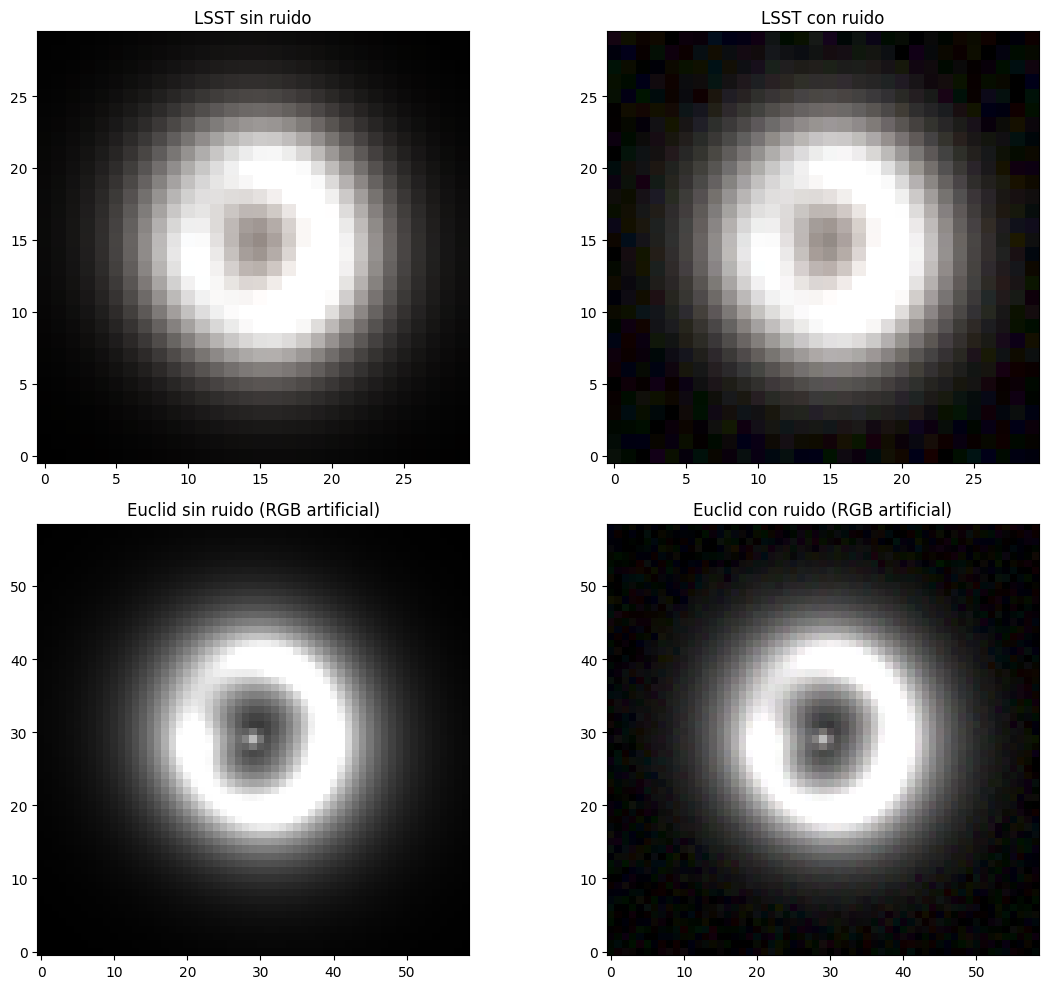

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Fila 1: LSST
axes[0, 0].imshow(scale_image_rgb(img_clean), origin='lower')
axes[0, 0].set_title("LSST sin ruido")

axes[0, 1].imshow(scale_image_rgb(img_noisy), origin='lower')
axes[0, 1].set_title("LSST con ruido")

# Fila 2: Euclid
axes[1, 0].imshow(scale_image_rgb(img_clean_euclid), origin='lower')
axes[1, 0].set_title("Euclid sin ruido (RGB artificial)")

axes[1, 1].imshow(scale_image_rgb(img_noisy_euclid), origin='lower')
axes[1, 1].set_title("Euclid con ruido (RGB artificial)")

plt.tight_layout()
plt.show()


---
### Con y sin subhalo

In [95]:
lens_base = {'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}

subhalo = {'theta_E': 0.05, 'center_x': 0.3, 'center_y': -0.2}  # SIS típico

# Lista de modelos para cada caso
lens_smooth = [lens_base]  # solo SIE
lens_perturbed = [lens_base, subhalo]  # SIE + SIS


In [96]:
def simulate_pair_with_subhalo(band_configs, model_config, lens_list_clean, lens_list_subhalo,
                               source_mag_list, size=6.0, kwargs_numerics=None):
    imgs_clean, imgs_subhalo = [], []

    for band_config, kwargs_source_mag in zip(band_configs, source_mag_list):
        kw_band = band_config.kwargs_single_band()
        pixel_scale = kw_band['pixel_scale']
        numpix = int(round(size / pixel_scale))

        sim = SimAPI(numpix, kw_band, model_config)
        _, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])
        imSim = sim.image_model_class(kwargs_numerics)

        img_clean = imSim.image(kwargs_lens=lens_list_clean, kwargs_source=kwargs_source,
                                kwargs_lens_light=None, kwargs_ps=None)
        img_perturbed = imSim.image(kwargs_lens=lens_list_subhalo, kwargs_source=kwargs_source,
                                    kwargs_lens_light=None, kwargs_ps=None)

        # Agregamos ruido a ambas
        img_clean += sim.noise_for_model(img_clean)
        img_perturbed += sim.noise_for_model(img_perturbed)

        imgs_clean.append(img_clean)
        imgs_subhalo.append(img_perturbed)

    return np.stack(imgs_clean, axis=-1), np.stack(imgs_subhalo, axis=-1)


In [97]:
lsst_bands = [LSST_g, LSST_r, LSST_i]
img_clean_sie, img_sie_sis = simulate_pair_with_subhalo(
    band_configs=lsst_bands,
    model_config=kwargs_model,
    lens_list_clean=[lens_base],
    lens_list_subhalo=[lens_base, subhalo],
    source_mag_list=[kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i],
    size=6.0,
    kwargs_numerics=kwargs_numerics
)


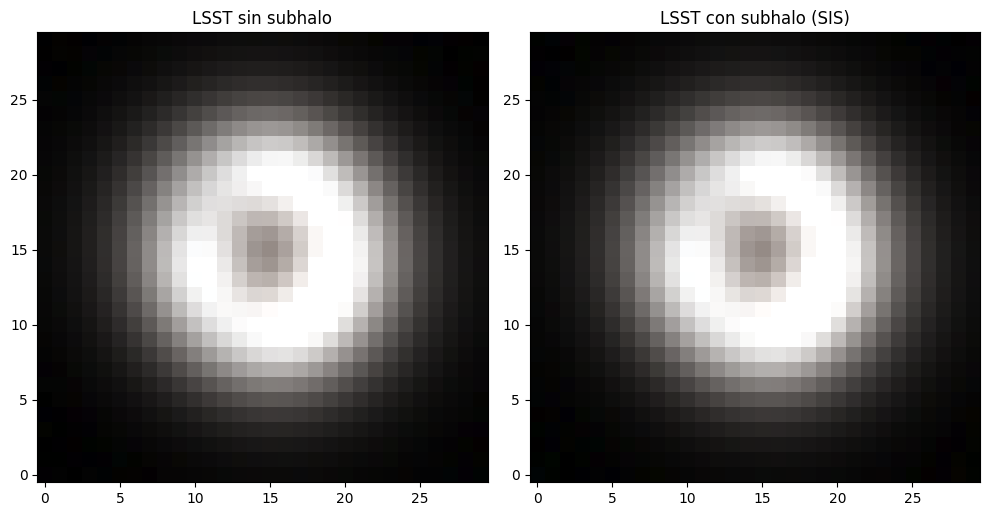

In [98]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(scale_image_rgb(img_clean_sie), origin='lower')
axes[0].set_title("LSST sin subhalo")

axes[1].imshow(scale_image_rgb(img_sie_sis), origin='lower')
axes[1].set_title("LSST con subhalo (SIS)")

plt.tight_layout()
plt.show()


In [99]:
def simulate_pair_with_subhalo_and_noise(band_configs, model_config,
                                         lens_base, subhalo_params,
                                         source_mag_list, size=6.0, kwargs_numerics=None):
    lens_clean = [lens_base]
    lens_subhalo = [lens_base, subhalo_params]

    imgs_clean, imgs_subhalo = [], []

    for band_config, kwargs_source_mag in zip(band_configs, source_mag_list):
        kw = band_config.kwargs_single_band()
        numpix = int(round(size / kw['pixel_scale']))
        sim = SimAPI(numpix, kw, model_config)
        _, kwargs_source, _ = sim.magnitude2amplitude([], kwargs_source_mag, [])
        imSim = sim.image_model_class(kwargs_numerics)

        # Imagen limpia sin nada
        img_clean = imSim.image(lens_clean, kwargs_source, None, None)
        imgs_clean.append(img_clean)

        # Imagen perturbada con subhalo
        img_sub_no_noise = imSim.image(lens_subhalo, kwargs_source, None, None)
        img_subhalo = img_sub_no_noise + sim.noise_for_model(img_sub_no_noise)
        imgs_subhalo.append(img_subhalo)

    return np.stack(imgs_clean, axis=-1), np.stack(imgs_subhalo, axis=-1)


In [106]:
# Definimos el modelo base y el subhalo
lens_base = {'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}
subhalo = {'theta_E': 0.05, 'center_x': 0.2, 'center_y': -0.15}

# Colores por banda
mag_g = 21
g_r = 1.0
g_i = 2.0

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': 0.1, 'center_y': 0.05}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

source_mags = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]


# Simulación
img_clean, img_noisy_subhalo = simulate_pair_with_subhalo_and_noise(
    band_configs=lsst_bands,
    model_config=kwargs_model,
    lens_base=lens_base,
    subhalo_params=subhalo,
    source_mag_list=[kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i],
    size=6.0,
    kwargs_numerics=kwargs_numerics
)


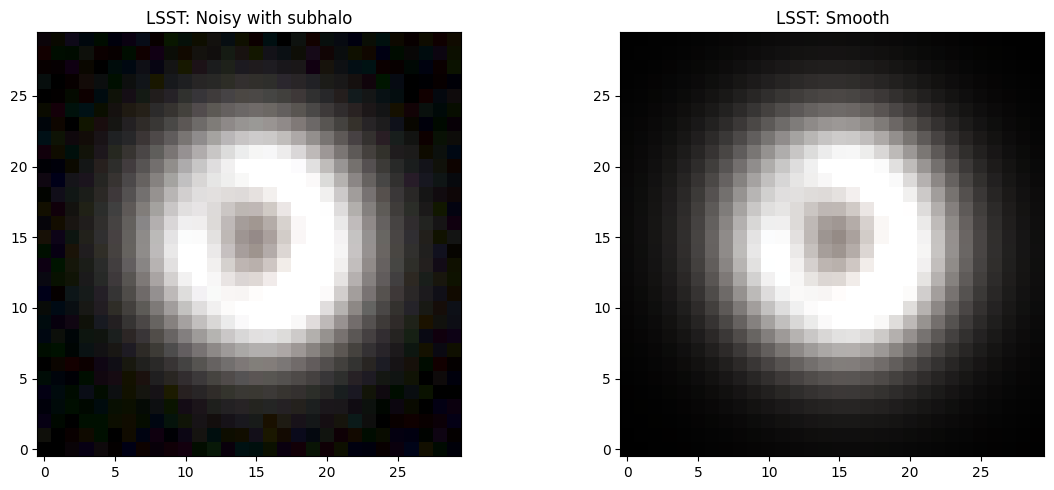

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[1].imshow(scale_image_rgb(img_clean), origin='lower')
axes[1].set_title("LSST: Smooth")

axes[0].imshow(scale_image_rgb(img_noisy_subhalo), origin='lower')
axes[0].set_title("LSST: Noisy with subhalo")

plt.tight_layout()
plt.show()


In [120]:
from lenstronomy.SimulationAPI.ObservationConfig.Euclid import Euclid

# Tres instancias VIS para simular multibanda
Euclid_g = Euclid(band='VIS', coadd_years=6)
Euclid_r = Euclid(band='VIS', coadd_years=6)
Euclid_i = Euclid(band='VIS', coadd_years=6)

euclid_bands = [Euclid_g, Euclid_r, Euclid_i]

# Colores por banda
mag_g = 18
g_r = 1.0
g_i = 2.0

kwargs_source_mag_g = [{'magnitude': mag_g, 'R_sersic': 0.4, 'n_sersic': 1,
                        'e1': 0.05, 'e2': -0.05, 'center_x': 0.1, 'center_y': 0.05}]
kwargs_source_mag_r = [{'magnitude': mag_g - g_r, **kwargs_source_mag_g[0]}]
kwargs_source_mag_i = [{'magnitude': mag_g - g_i, **kwargs_source_mag_g[0]}]

source_mags = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]


In [121]:
# Lente principal
lens_base = {'theta_E': 1.0, 'e1': 0.2, 'e2': 0.0, 'center_x': 0, 'center_y': 0}

# Subhalo
subhalo = {'theta_E': 0.05, 'center_x': 0.2, 'center_y': -0.15}

# Magnitudes por banda
source_mags_euclid = [kwargs_source_mag_g, kwargs_source_mag_r, kwargs_source_mag_i]


In [122]:
img_clean_euclid, img_subhalo_euclid = simulate_pair_with_subhalo_and_noise(
    band_configs=euclid_bands,
    model_config=kwargs_model,
    lens_base=lens_base,
    subhalo_params=subhalo,
    source_mag_list=source_mags_euclid,
    size=6.0,
    kwargs_numerics=kwargs_numerics
)


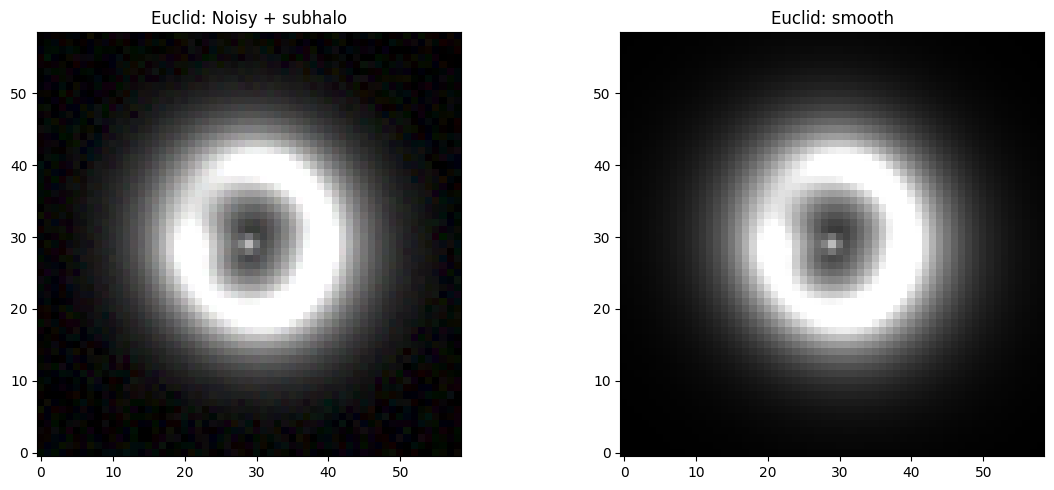

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[1].imshow(scale_image_rgb(img_clean_euclid), origin='lower')
axes[1].set_title("Euclid: smooth")

axes[0].imshow(scale_image_rgb(img_subhalo_euclid), origin='lower')
axes[0].set_title("Euclid: Noisy + subhalo")

plt.tight_layout()
plt.show()
